In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from rdkit import Chem
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Setup complete | Using device:", device)


✅ Setup complete | Using device: cuda


In [ ]:
import pandas as pd
from rdkit import Chem
chembl_file = "/datasets/ChEMBL.txt"
atom_file   = "/datasets/atom_types.txt"
with open(chembl_file, "r") as f:
    smiles_list = [line.strip() for line in f if line.strip()]
print(f"📥 Loaded total molecules: {len(smiles_list)}")
smiles_list = smiles_list[:100_000]
print(f"✅ Using subset: {len(smiles_list)} molecules")
with open(atom_file, "r") as f:
    atom_types = [line.strip() for line in f if line.strip()]
print(f"📖 Loaded {len(atom_types)} atom types")
valid_smiles = []
for smi in smiles_list:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        valid_smiles.append(Chem.MolToSmiles(mol))
print(f"✅ Valid SMILES retained: {len(valid_smiles)}")
df = pd.DataFrame(valid_smiles, columns=["smiles"])
df.to_csv("processed_smiles.csv", index=False)
print("💾 Processed data saved: processed_smiles.csv")
df.head()


📥 Loaded total molecules: 1488640
✅ Using subset: 100000 molecules
📖 Loaded 33 atom types
✅ Valid SMILES retained: 100000
💾 Processed data saved: processed_smiles.csv


,smiles
0,c1cc(OCCCN2CCCCC2)ccc1CN1CCC2(CC1)OCCO2
1,CC1COC(c2cccn2Cc2ccccc2Cl)=N1
2,Cc1ncn(-c2ccc(C#N)nc2-c2nc3cc(-c4cnc(N)nc4)ccc...
3,Cc1c(-c2ccc(-c3cccnc3)cc2)nc2ccc(F)cc2c1C(=O)O
4,Cn1c(=O)c2c(SCC(=O)N3CCOCC3)nc(-c3ccccc3F)nc2n...


In [3]:
from torch.utils.data import Dataset, DataLoader
import torch
special_tokens = ["<PAD>", "<SOS>", "<EOS>", "<UNK>"]
unique_chars = sorted(set("".join(smiles_list)))
itos = special_tokens + unique_chars
stoi = {ch: i for i, ch in enumerate(itos)}
VOCAB_SIZE = len(itos)
print("✅ Vocab size:", VOCAB_SIZE)
print("Sample tokens:", itos[:20])
def encode(smiles, max_len=120):
    tokens = [stoi.get(ch, stoi["<UNK>"]) for ch in smiles]
    tokens = [stoi["<SOS>"]] + tokens + [stoi["<EOS>"]]
    if len(tokens) < max_len:
        tokens += [stoi["<PAD>"]] * (max_len - len(tokens))
    else:
        tokens = tokens[:max_len]
    return torch.tensor(tokens, dtype=torch.long)
def decode(indices):
    return "".join([itos[i] for i in indices if i not in
                    (stoi["<PAD>"], stoi["<SOS>"], stoi["<EOS>"])])
class SMILESDataset(Dataset):
    def __init__(self, smiles_list, max_len=120):
        self.smiles_list = smiles_list
        self.max_len = max_len
    def __len__(self):
        return len(self.smiles_list)
    def __getitem__(self, idx):
        seq = encode(self.smiles_list[idx], self.max_len)
        x = seq[:-1]
        y = seq[1:]
        return x, y
split = int(0.9 * len(smiles_list))
train_data = SMILESDataset(smiles_list[:split])
val_data = SMILESDataset(smiles_list[split:])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)
print("✅ Data prepared: train =", len(train_data), "val =", len(val_data))


✅ Vocab size: 37
Sample tokens: ['<PAD>', '<SOS>', '<EOS>', '<UNK>', '#', '(', ')', '+', '-', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'B']
✅ Data prepared: train = 90000 val = 10000


In [6]:
import torch.nn as nn
import torch
from tqdm import tqdm
import time
class SMILESLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=512, num_layers=2, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=stoi["<PAD>"])
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        return out, hidden
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)
model = SMILESLanguageModel(vocab_size=VOCAB_SIZE).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=stoi["<PAD>"])
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3
)
print("✅ Model ready on", device)
def train_model(model, train_loader, val_loader, epochs=50, patience=7, save_interval=10):
    best_val_loss = float("inf")
    patience_counter = 0
    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0
        start_time = time.time()
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", unit="batch"):
            x, y = x.to(device), y.to(device)
            y = torch.clamp(y, 0, VOCAB_SIZE-1)
            optimizer.zero_grad()
            output, _ = model(x)
            loss = criterion(output.transpose(1, 2), y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                y = torch.clamp(y, 0, VOCAB_SIZE-1)
                output, _ = model(x)
                loss = criterion(output.transpose(1, 2), y)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)
        elapsed = time.time() - start_time
        print(f"Epoch [{epoch}/{epochs}] complete | Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Time: {elapsed:.2f}s")
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_smiles_model.pth")
            print("✅ Model saved (improved val loss)")
        else:
            patience_counter += 1
        if epoch % save_interval == 0:
            torch.save(model.state_dict(), f"smiles_model_epoch{epoch}.pth")
            print(f"💾 Model checkpoint saved at epoch {epoch}")
        if patience_counter >= patience:
            print("⏹️ Early stopping triggered")
            torch.save(model.state_dict(), f"smiles_model_earlystop_epoch{epoch}.pth")
            print(f"💾 Model saved at early stopping (epoch {epoch})")
            break
    print("🎉 Training complete. Best Val Loss:", best_val_loss)
train_model(model, train_loader, val_loader, epochs=50, patience=7, save_interval=10)


✅ Using device: cuda
✅ Model ready on cuda


Epoch 1/50: 100%|██████████| 1407/1407 [01:25<00:00, 16.51batch/s]


Epoch [1/50] complete | Train Loss: 0.8589 | Val Loss: 0.7278 | Time: 88.99s
✅ Model saved (improved val loss)


Epoch 2/50: 100%|██████████| 1407/1407 [01:25<00:00, 16.47batch/s]


Epoch [2/50] complete | Train Loss: 0.7057 | Val Loss: 0.6842 | Time: 89.22s
✅ Model saved (improved val loss)


Epoch 3/50: 100%|██████████| 1407/1407 [01:25<00:00, 16.40batch/s]


Epoch [3/50] complete | Train Loss: 0.6696 | Val Loss: 0.6618 | Time: 89.63s
✅ Model saved (improved val loss)


Epoch 4/50: 100%|██████████| 1407/1407 [01:26<00:00, 16.32batch/s]


Epoch [4/50] complete | Train Loss: 0.6463 | Val Loss: 0.6479 | Time: 90.06s
✅ Model saved (improved val loss)


Epoch 5/50: 100%|██████████| 1407/1407 [01:26<00:00, 16.31batch/s]


Epoch [5/50] complete | Train Loss: 0.6282 | Val Loss: 0.6392 | Time: 90.10s
✅ Model saved (improved val loss)


Epoch 6/50: 100%|██████████| 1407/1407 [01:26<00:00, 16.34batch/s]


Epoch [6/50] complete | Train Loss: 0.6136 | Val Loss: 0.6324 | Time: 89.94s
✅ Model saved (improved val loss)


Epoch 7/50: 100%|██████████| 1407/1407 [01:25<00:00, 16.40batch/s]


Epoch [7/50] complete | Train Loss: 0.6007 | Val Loss: 0.6262 | Time: 89.60s
✅ Model saved (improved val loss)


Epoch 8/50: 100%|██████████| 1407/1407 [01:25<00:00, 16.43batch/s]


Epoch [8/50] complete | Train Loss: 0.5900 | Val Loss: 0.6226 | Time: 89.43s
✅ Model saved (improved val loss)


Epoch 9/50: 100%|██████████| 1407/1407 [01:25<00:00, 16.46batch/s]


Epoch [9/50] complete | Train Loss: 0.5808 | Val Loss: 0.6189 | Time: 89.28s
✅ Model saved (improved val loss)


Epoch 10/50: 100%|██████████| 1407/1407 [01:25<00:00, 16.43batch/s]


Epoch [10/50] complete | Train Loss: 0.5723 | Val Loss: 0.6170 | Time: 89.48s
✅ Model saved (improved val loss)
💾 Model checkpoint saved at epoch 10


Epoch 11/50: 100%|██████████| 1407/1407 [01:25<00:00, 16.36batch/s]


Epoch [11/50] complete | Train Loss: 0.5654 | Val Loss: 0.6169 | Time: 89.82s
✅ Model saved (improved val loss)


Epoch 12/50: 100%|██████████| 1407/1407 [01:26<00:00, 16.33batch/s]


Epoch [12/50] complete | Train Loss: 0.5591 | Val Loss: 0.6152 | Time: 89.98s
✅ Model saved (improved val loss)


Epoch 13/50: 100%|██████████| 1407/1407 [01:25<00:00, 16.40batch/s]


Epoch [13/50] complete | Train Loss: 0.5537 | Val Loss: 0.6140 | Time: 89.57s
✅ Model saved (improved val loss)


Epoch 14/50: 100%|██████████| 1407/1407 [01:25<00:00, 16.37batch/s]


Epoch [14/50] complete | Train Loss: 0.5486 | Val Loss: 0.6143 | Time: 89.78s


Epoch 15/50: 100%|██████████| 1407/1407 [01:26<00:00, 16.32batch/s]


Epoch [15/50] complete | Train Loss: 0.5442 | Val Loss: 0.6141 | Time: 90.06s


Epoch 16/50: 100%|██████████| 1407/1407 [01:26<00:00, 16.35batch/s]


Epoch [16/50] complete | Train Loss: 0.5404 | Val Loss: 0.6149 | Time: 89.87s


Epoch 17/50: 100%|██████████| 1407/1407 [01:25<00:00, 16.42batch/s]


Epoch [17/50] complete | Train Loss: 0.5371 | Val Loss: 0.6144 | Time: 89.50s


Epoch 18/50: 100%|██████████| 1407/1407 [01:26<00:00, 16.36batch/s]


Epoch [18/50] complete | Train Loss: 0.5113 | Val Loss: 0.6060 | Time: 89.84s
✅ Model saved (improved val loss)


Epoch 19/50: 100%|██████████| 1407/1407 [01:25<00:00, 16.41batch/s]


Epoch [19/50] complete | Train Loss: 0.5002 | Val Loss: 0.6070 | Time: 89.59s


Epoch 20/50: 100%|██████████| 1407/1407 [01:25<00:00, 16.39batch/s]


Epoch [20/50] complete | Train Loss: 0.4943 | Val Loss: 0.6093 | Time: 89.66s
💾 Model checkpoint saved at epoch 20


Epoch 21/50: 100%|██████████| 1407/1407 [01:25<00:00, 16.46batch/s]


Epoch [21/50] complete | Train Loss: 0.4894 | Val Loss: 0.6095 | Time: 89.25s


Epoch 22/50: 100%|██████████| 1407/1407 [01:25<00:00, 16.46batch/s]


Epoch [22/50] complete | Train Loss: 0.4850 | Val Loss: 0.6119 | Time: 89.32s


Epoch 23/50: 100%|██████████| 1407/1407 [01:25<00:00, 16.43batch/s]


Epoch [23/50] complete | Train Loss: 0.4691 | Val Loss: 0.6109 | Time: 89.47s


Epoch 24/50: 100%|██████████| 1407/1407 [01:25<00:00, 16.39batch/s]


Epoch [24/50] complete | Train Loss: 0.4630 | Val Loss: 0.6119 | Time: 89.65s


Epoch 25/50: 100%|██████████| 1407/1407 [01:25<00:00, 16.42batch/s]


Epoch [25/50] complete | Train Loss: 0.4591 | Val Loss: 0.6142 | Time: 89.54s
⏹️ Early stopping triggered
💾 Model saved at early stopping (epoch 25)
🎉 Training complete. Best Val Loss: 0.6060014989725344


In [7]:
model.load_state_dict(torch.load("best_smiles_model.pth", map_location=device))
model.eval()
print("✅ Best model loaded for evaluation")


✅ Best model loaded for evaluation


In [10]:
import math
from tqdm import tqdm
total_tokens = 0
correct_tokens = 0
val_loss = 0
with torch.no_grad():
    for x, y in tqdm(val_loader, desc="Token-level Evaluation"):
        x, y = x.to(device), y.to(device)
        output, _ = model(x)
        loss = criterion(output.transpose(1, 2), y)
        val_loss += loss.item()
        pred = output.argmax(dim=2)
        mask = (y != stoi["<PAD>"])
        correct_tokens += (pred == y).masked_select(mask).sum().item()
        total_tokens += mask.sum().item()
avg_val_loss = val_loss / len(val_loader)
perplexity = math.exp(avg_val_loss)
token_accuracy = correct_tokens / total_tokens * 100
print("\n📊 Token-level Evaluation:")
print(f"Validation Loss: {avg_val_loss:.4f} | Perplexity: {perplexity:.2f}")
print(f"Token-level Accuracy: {token_accuracy:.2f}%")


Token-level Evaluation: 100%|██████████| 157/157 [00:03<00:00, 40.89it/s]


📊 Token-level Evaluation:
Validation Loss: 0.6060 | Perplexity: 1.83
Token-level Accuracy: 79.12%


In [17]:
import torch
import torch.nn.functional as F
import random
def generate_smiles(model, stoi, itos, max_len=120, temperature=0.8, top_k=5, n_samples=10):
    model.eval()
    generated_smiles = []
    for _ in range(n_samples):
        input_seq = torch.tensor([[stoi["<SOS>"]]], device=device)
        hidden = None
        smile = ""
        for _ in range(max_len):
            output, hidden = model(input_seq, hidden)
            logits = output[:, -1, :] / temperature
            top_probs, top_idx = torch.topk(F.softmax(logits, dim=-1), top_k)
            top_idx = top_idx.squeeze()
            top_probs = top_probs.squeeze()
            next_token = random.choices(top_idx.cpu().detach().numpy(),
                                        weights=top_probs.cpu().detach().numpy(), k=1)[0]
            if next_token == stoi["<EOS>"]:
                break
            smile += itos[next_token]
            input_seq = torch.tensor([[next_token]], device=device)
        generated_smiles.append(smile)
    return generated_smiles


In [18]:
n_samples = 20
generated = generate_smiles(model, stoi, itos, max_len=120, temperature=0.8, top_k=5, n_samples=n_samples)
for i, smi in enumerate(generated, 1):
    print(f"{i}: {smi}")


1: CC(C)(C)C(=O)NC(Cc1ccc(OCC(=O)O)cc1)C(=O)O
2: CC(C)(C)c1ccc(NC(=O)N2CCCC(CO)(Cc3ccccc3)C2C(=O)NO)cc1
3: Nc1ccc(-c2cn(-c3ccc(O)cc3)c3c(Cl)c(Cl)ccc3c2=O)cc1
4: Cn1c(=O)c2c(ncn2CC(=O)N2CCN(c3ccc(F)cc3)CC2)n(C)c1=O
5: O=C(CCCn1c(=O)c2cccn2c2cccnc21)NCCN1CCOCC1
6: CC(=O)OC1c2c(ccc3c(=O)c4c(oc(CCCCC)n2C)CCC4)OC(C)(C)C=C3C1
7: CC(=O)c1cccc(NC(=O)Nc2ccc3[nH]cc(C(=O)NCCc4ccco4)c(=O)c3c2)c1
8: COc1ccc(C(=O)COC(=O)C2(O)CCCCC2)cc1
9: Cc1ccc(C)c(N2CCN(C(=O)CCc3ccccc3)CC2)c1
10: CNC(=O)CN(C)C(=O)c1ccc(C(=O)NC(Cc2cc(F)cc(F)c2)C(O)CNCc2cccc(OC)c2)cc1
11: COC(=O)n1c(=O)c(-c2ccccc2)nc2cnc(Nc3ccccc3)nc21
12: CC(=O)CC1(O)C(=O)N(CCc2ccccc2)c2ccccc21
13: CCOC(=O)C(C#N)=Cc1ccc(OCc2ccc3ccccc3n2)cc1
14: O=C(CN1C(=O)NC2(CCOCC2)C1=O)c1cccnc1
15: CC(C)(C)OC(=O)N1CCC(n2cc(Nc3ncc(C(F)(F)F)cc3S(=O)(=O)C(C)C)nn2)CC1
16: CC(NC(=O)C(Cc1ccc(OP(=O)(O)O)cc1)NC(=O)C(CO)NC(=O)C(Cc1ccccc1)NC(=O)C(NC(=O)c1cccc(C(=O)O)c1)C(C)C)C(=O)O
17: Oc1ccc2cc1Oc1ccc(cc1)CCCCCCCC(F)(F)C(F)(F)C(F)C(O)C(F)(F)C2
18: CCCCCCCCCCCCCCCCCCCC(N)

In [20]:
from rdkit import Chem
from tqdm import tqdm
valid_smiles_count = 0
total_smiles = len(generated)
for smi in tqdm(generated, desc="Checking SMILES Validity"):
    if Chem.MolFromSmiles(smi) is not None:
        valid_smiles_count += 1
valid_smiles_pct = (valid_smiles_count / total_smiles) * 100
print("\n📊 Generated SMILES Validity:")
print(f"Valid SMILES: {valid_smiles_pct:.2f}% ({valid_smiles_count}/{total_smiles})")


Checking SMILES Validity: 100%|██████████| 20/20 [00:00<00:00, 3181.24it/s]


📊 Generated SMILES Validity:
Valid SMILES: 95.00% (19/20)


[07:39:09] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 12 13 15


✅ 9 valid molecules will be visualized out of 20 generated.


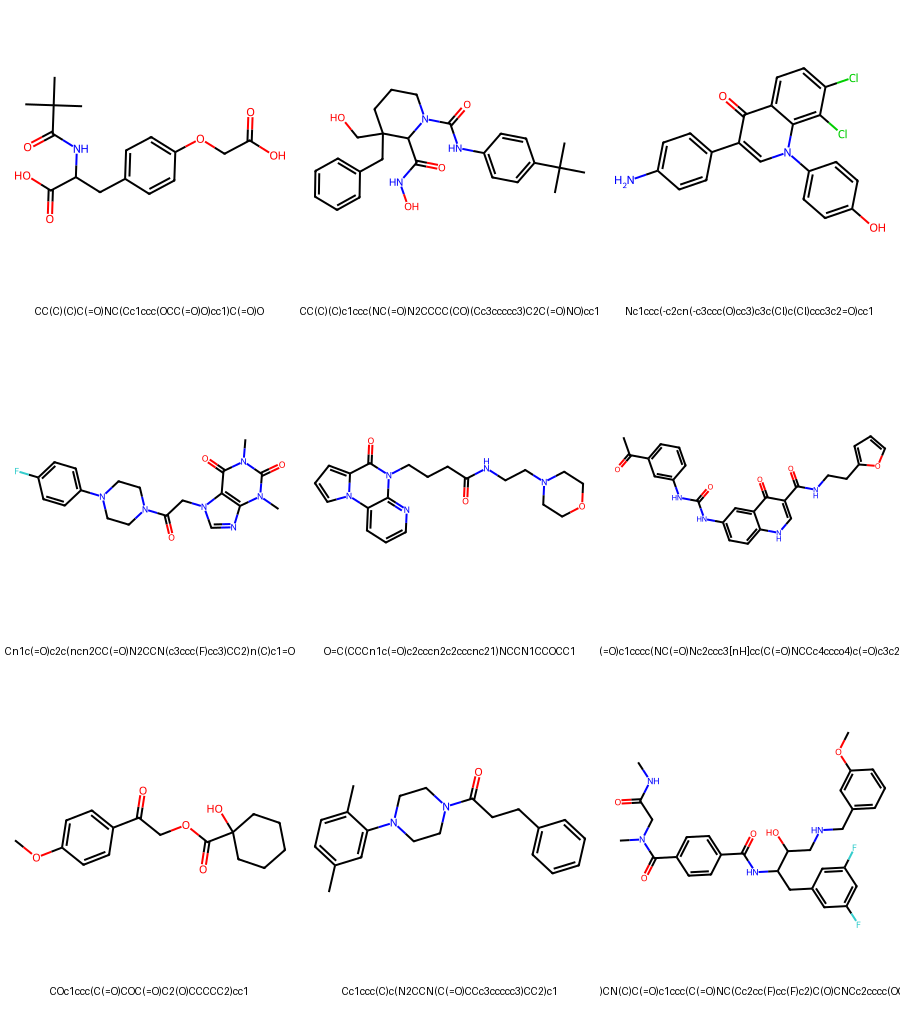

In [42]:
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
def draw_valid_molecules_grid_with_labels(smiles_list, max_mols=5, mols_per_row=3, sub_img_size=(300,300)):
    mols = []
    labels = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            try:
                Chem.Kekulize(mol, clearAromaticFlags=True)
                Chem.rdDepictor.Compute2DCoords(mol)
                mols.append(mol)
                labels.append(smi)
            except:
                continue
        if len(mols) >= max_mols:
            break
    print(f"✅ {len(mols)} valid molecules will be visualized out of {len(smiles_list)} generated.")
    imgs = [Draw.MolToImage(mol, size=sub_img_size, kekulize=True, bgColor=(255,255,255)) for mol in mols]
    labeled_imgs = []
    for img, label in zip(imgs, labels):
        new_img = Image.new('RGB', (sub_img_size[0], sub_img_size[1]+40), color=(255,255,255))
        new_img.paste(img, (0,0))
        draw = ImageDraw.Draw(new_img)
        try:
            font = ImageFont.truetype("arial.ttf", 16)
        except:
            font = ImageFont.load_default()
        bbox = draw.textbbox((0,0), label, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]
        draw.text(((sub_img_size[0]-text_width)//2, sub_img_size[1]+5), label, fill=(0,0,0), font=font)
        labeled_imgs.append(new_img)
    rows = (len(labeled_imgs) + mols_per_row - 1) // mols_per_row
    grid_img = Image.new('RGB', (sub_img_size[0]*mols_per_row, (sub_img_size[1]+40)*rows), color=(255,255,255))
    for idx, img in enumerate(labeled_imgs):
        x = (idx % mols_per_row) * sub_img_size[0]
        y = (idx // mols_per_row) * (sub_img_size[1]+40)
        grid_img.paste(img, (x,y))
    return grid_img
grid_image = draw_valid_molecules_grid_with_labels(generated, max_mols=9, mols_per_row=3)
display(grid_image)
